In [4]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/sabinako/attractions/refs/heads/main/places_in_france.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(url)

# Display first few rows of the data
print(df.head())


   id                                      name          type  longitude  \
0  62                 Maison forte de Capchicot  architecture  -0.042249   
1  63                   Ancienne Bergerie ronde  architecture  -0.112605   
2  64                      Église de Montarouch  architecture  -0.261540   
3  66  Villa gallo-romaine de la Coue d'Auzenat  architecture  -0.028225   
4  67                     Aqueduc (restes d'un)  architecture  -0.028328   

    latitude  
0  44.183838  
1  44.316288  
2  44.755581  
3  45.331112  
4  45.331383  


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



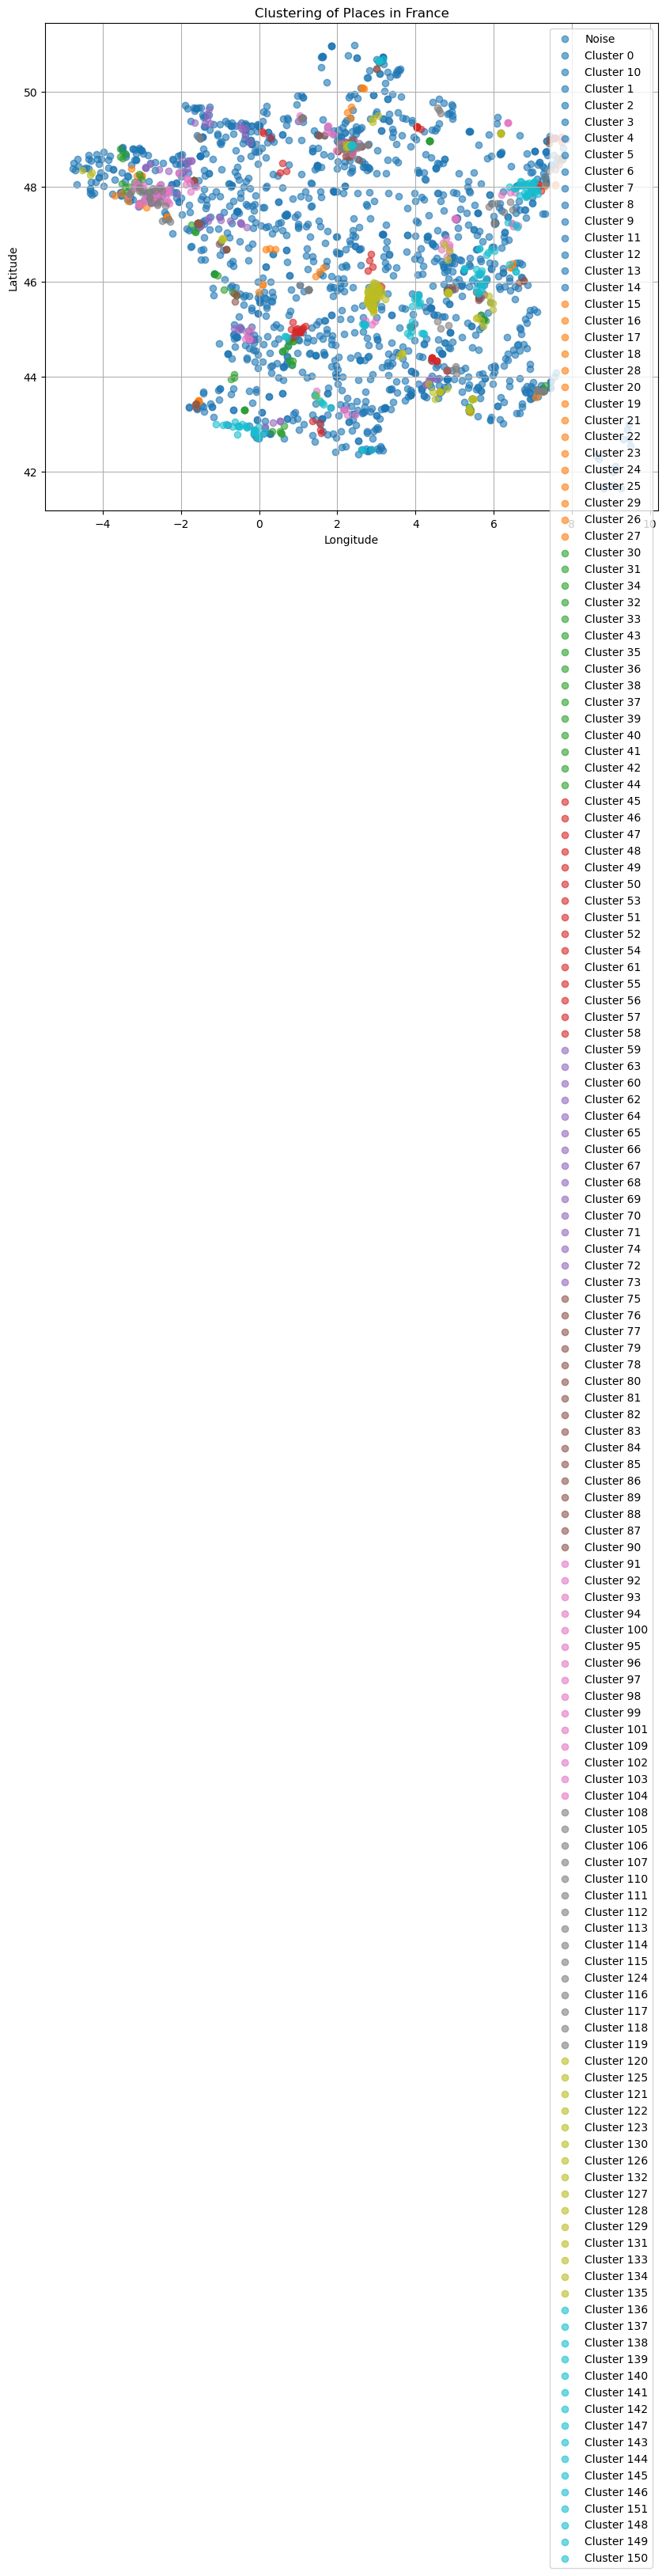

Cluster Statistics:

Cluster 0:
  Center: (45.4738, 0.0964)
  Size: 8 points

Cluster 1:
  Center: (47.2807, -1.4138)
  Size: 3 points

Cluster 2:
  Center: (49.2718, -1.1716)
  Size: 6 points

Cluster 3:
  Center: (49.2116, -0.2969)
  Size: 3 points

Cluster 4:
  Center: (44.2228, 0.4456)
  Size: 4 points

Cluster 5:
  Center: (44.7696, 0.8892)
  Size: 5 points

Cluster 6:
  Center: (43.4527, 5.3811)
  Size: 4 points

Cluster 7:
  Center: (43.9265, 4.6192)
  Size: 7 points

Cluster 8:
  Center: (44.4981, 4.6679)
  Size: 5 points

Cluster 9:
  Center: (43.7028, 7.2615)
  Size: 3 points

Cluster 10:
  Center: (46.0162, 0.1121)
  Size: 3 points

Cluster 11:
  Center: (47.3937, 0.7338)
  Size: 5 points

Cluster 12:
  Center: (47.3186, 5.0412)
  Size: 3 points

Cluster 13:
  Center: (48.8629, 2.2768)
  Size: 21 points

Cluster 14:
  Center: (49.4363, 1.0896)
  Size: 3 points

Cluster 15:
  Center: (49.5590, 2.3126)
  Size: 3 points

Cluster 16:
  Center: (49.2526, 4.0377)
  Size: 3 points


In [118]:
''' applying clustering onto cleaned places_in_france.csv to see the cluster statistics, also first visualization on a map in france'''

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict

# Haversine formula for calculating distances
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Radius of Earth in kilometers

# Clustering function
def cluster_places(data, eps_km=10):
    # Prepare data
    coords = data[['latitude', 'longitude']].values
    type_categories = pd.Categorical(data['type'])
    type_codes = type_categories.codes
    features = np.column_stack([coords, type_codes.reshape(-1, 1) * 0.5])

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply DBSCAN
    eps_scaled = eps_km / 111.0  # Approximation for kilometers to degrees
    clustering = DBSCAN(eps=eps_scaled, min_samples=3).fit(features_scaled)

    # Add cluster labels
    data['cluster'] = clustering.labels_
    return data, clustering

# Visualization function
def visualize_clusters(data):
    plt.figure(figsize=(10, 8))
    unique_clusters = data['cluster'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    for cluster_id, color in zip(unique_clusters, colors):
        cluster_data = data[data['cluster'] == cluster_id]
        label = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise"
        plt.scatter(
            cluster_data['longitude'], 
            cluster_data['latitude'], 
            color=color, 
            label=label, 
            alpha=0.6
        )

    plt.title("Clustering of Places in France")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid()
    plt.show()

# Load data
url = "https://raw.githubusercontent.com/sabinako/attractions/refs/heads/main/places_in_france.csv"
data = pd.read_csv(url)

# Ensure columns are as expected
required_columns = {'id', 'name', 'type', 'longitude', 'latitude'}
if not required_columns.issubset(data.columns):
    raise ValueError(f"Missing columns in data. Expected {required_columns}, found {data.columns}")

# Perform clustering
clustered_data, clustering_model = cluster_places(data)

# Visualize clusters
visualize_clusters(clustered_data)

# Print some cluster stats
print("Cluster Statistics:")
for cluster_id in sorted(clustered_data['cluster'].unique()):
    cluster_points = clustered_data[clustered_data['cluster'] == cluster_id]
    if cluster_id != -1:  # Ignore noise
        center_lat = cluster_points['latitude'].mean()
        center_lon = cluster_points['longitude'].mean()
        print(f"\nCluster {cluster_id}:")
        print(f"  Center: ({center_lat:.4f}, {center_lon:.4f})")
        print(f"  Size: {len(cluster_points)} points")

In [96]:
'''changed code for Dashvisualization with filtering options and also possibility to adjust the radius of the choosen place; in this example min. 3 point for a cluster, Radius 15km'''

import pandas as pd
import numpy as np
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import DBSCAN

# Haversine distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth's radius in km

def cluster_places(data, eps_km=10):
    def haversine_distance_matrix(coords):
        n = coords.shape[0]
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = haversine_distance(
                    coords[i,0], coords[i,1], 
                    coords[j,0], coords[j,1]
                )
                distance_matrix[i,j] = dist
                distance_matrix[j,i] = dist
        return distance_matrix

    coords = data[['latitude', 'longitude']].values
    distances = haversine_distance_matrix(coords)
    
    clustering = DBSCAN(
        eps=eps_km,  # Directly in km
        min_samples=3, 
        metric='precomputed'
    ).fit(distances)
    
    data['cluster'] = clustering.labels_
    return data

# Load and cluster data
url = "https://raw.githubusercontent.com/sabinako/attractions/refs/heads/main/places_in_france.csv"
data = pd.read_csv(url)
clustered_data = cluster_places(data, eps_km=15)

# Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("France Travel Explorer"),
    
    html.Div([
        html.Div([
            html.Label("Select Place"),
            dcc.Dropdown(
                id='place-dropdown',
                options=[{'label': p, 'value': p} for p in clustered_data['name'].unique()],
                placeholder="Choose a place to explore"
            )
        ], style={'width': '30%', 'display': 'inline-block'}),
        
        html.Div([
            html.Label("Filter Attraction Types"),
            dcc.Dropdown(
                id='type-dropdown',
                options=[{'label': t, 'value': t} for t in clustered_data['type'].unique()],
                multi=True,
                placeholder="Select attraction types"
            )
        ], style={'width': '30%', 'display': 'inline-block'})
    ]),
    
    dcc.Graph(id='map-visualization'),
    
    html.Div([
        html.H3("Nearby Attractions"),
        dash_table.DataTable(
            id='nearby-attractions-table',
            columns=[
                {'name': 'Name', 'id': 'name'},
                {'name': 'Type', 'id': 'type'},
                {'name': 'Distance from Selected Place (km)', 'id': 'distance'}
            ],
            style_table={'overflowX': 'auto'},
            sort_action='native',
        )
    ])
])

@app.callback(
    [Output('map-visualization', 'figure'),
     Output('nearby-attractions-table', 'data')],
    [Input('place-dropdown', 'value'),
     Input('type-dropdown', 'value')]
)
def update_visualization(selected_place, selected_types):
    # Determine the data to display based on filters
    if not selected_place and not selected_types:
        # Show all data if no filters are applied
        display_data = clustered_data
        fig = px.scatter_mapbox(
            display_data, 
            lat='latitude', 
            lon='longitude', 
            color='type',
            hover_name='name',
            zoom=5, 
            height=600
        ).update_layout(mapbox_style="open-street-map")
        return fig, []
    
    # Filter data by type if selected
    if selected_types:
        display_data = clustered_data[clustered_data['type'].isin(selected_types)]
    else:
        display_data = clustered_data
    
    # If a specific place is selected
    if selected_place:
        selected_row = clustered_data[clustered_data['name'] == selected_place].iloc[0]
        
        # Calculate distances from selected place
        display_data = display_data.copy()
        display_data['distance'] = display_data.apply(
            lambda row: haversine_distance(
                selected_row['latitude'], selected_row['longitude'], 
                row['latitude'], row['longitude']
            ) if row['name'] != selected_place else 0, 
            axis=1
        )
        
        # Prepare map visualization centered on selected place
        fig = px.scatter_mapbox(
            display_data, 
            lat='latitude', 
            lon='longitude', 
            color='type',
            hover_name='name',
            hover_data={'distance': ':.2f'},
            zoom=8, 
            center={'lat': selected_row['latitude'], 'lon': selected_row['longitude']},
            height=600
        )
    else:
        # Map visualization when no specific place is selected
        fig = px.scatter_mapbox(
            display_data, 
            lat='latitude', 
            lon='longitude', 
            color='type',
            hover_name='name',
            zoom=5, 
            height=600
        )
    
    fig.update_layout(mapbox_style="open-street-map")
    
    # Prepare nearby attractions data
    if selected_place:
        nearby_attractions = display_data[
            (display_data['name'] != selected_place) & 
            (display_data['distance'] <= 15)  # Adjust radius!!! 
        ].sort_values('distance')[
            ['name', 'type', 'distance']
        ].to_dict('records')
    else:
        nearby_attractions = []
    
    return fig, nearby_attractions

if __name__ == '__main__':
    app.run_server(debug=True)

In [107]:
import pandas as pd
from IPython.display import FileLink

# Perform clustering
clustered_data = cluster_places(data, eps_km=15)

# Save the DataFrame as a CSV file
clustered_data.to_csv('clustered_places.csv', index=False)

# Create a download link in the notebook
FileLink('clustered_places.csv')


/Users/sabinakolliwer/clustered_places.csv